# Identifying Atributte + Brand Association

## Set up

### Libraries

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

import string

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 8]

#hide all warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Only run on first iteration to download "popular" packages#
#nltk.download()

### Directories

In [64]:
data_dir = "../data/"
plots_dir = "../plots/"

### Data

In [4]:
comments = pd.read_csv(data_dir+"branded_comments.csv")
comments.head()
comments.review_text[0]

'curious to see how toyota sales are going to be over the next few months. with the bad news on crash data i will be interested if consumers even care about crash tests. my prediction is the honda honda will move to number 1, the ford will be 2, toyota 3, nissan 4, malbu 5 \n0  '

## Identify & Group Attributes

### Tokenization + Position Tagging

In [5]:
comments.head()

,Unnamed: 0,user_name,date,review_text,year
0,16928,cannon3,2013-01-01 01:01:25+00:00,curious to see how toyota sales are going to b...,2013
1,16929,[Deleted User],2013-01-01 01:34:33+00:00,i don't think there is any way that the ford c...,2013
2,16930,ajr1775,2013-01-02 00:27:03+00:00,the car is as advertised. picked it up last ni...,2013
3,16931,stickguy,2013-01-02 00:57:32+00:00,sounds like a good deal. i just described it t...,2013
4,16932,ajr1775,2013-01-02 01:20:09+00:00,that rate i got was based on 12k miles per yea...,2013


In [9]:
# function to convert pos tags into compatible wordnet tags for lemmatization
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [6]:
# list of tokens to remove after pos tagging and tokenisation to speed up lemmetization
rem_list = list(string.digits) + list(string.punctuation)+ stopwords.words('english')

In [7]:
tokenized_comments = []

for comment in comments.review_text:
    words = word_tokenize(comment) #tokenize words
    pos_tags = pd.Series(nltk.pos_tag(words)) #add pos tags
    keep_in = [i for i in range(len(words)) if not words[i] in rem_list] #index of tokens to keep in comment
    pos_tags= pos_tags[keep_in] # filter out unwanted words from comment
    tokenized_comments.append(pos_tags.values) # store comments in array

tokenized_comments = pd.Series(tokenized_comments, index=comments.index)
tokenized_comments.head()

0    [(curious, JJ), (see, VB), (toyota, JJ), (sale...
1    [(n't, RB), (think, VB), (way, NN), (ford, NN)...
2    [(car, NN), (advertised, JJ), (picked, VBD), (...
3    [(sounds, NNS), (like, IN), (good, JJ), (deal,...
4    [(rate, NN), (got, VBD), (based, VBN), (12k, C...
dtype: object

### Lemmetization

In [10]:
wl  = WordNetLemmatizer()
lem_count = pd.DataFrame(index = comments.index)

for index, comment in tokenized_comments.iteritems():
    for word, pos in comment:
        pos = get_wordnet_pos(pos) # convert to compatible pos tag for lemmetization
        lem_word = wl.lemmatize(word, pos=pos) # lemmatize word
        if lem_word not in lem_count.columns:
            # create new key for lemmatized word and count array based on comment number
            lem_count.loc[:,lem_word] = 0
        lem_count.loc[index, lem_word]=1 # binary count of lemmtized word in comment

In [11]:
brands = pd.read_csv(data_dir+"clean_model_map.csv")
brands = brands.brand.unique()
brands = [brand for brand in brands if brand in lem_count.columns] # index to seperate brands from lemmatized words

In [12]:
brand_counts = lem_count.copy()[brands] # create seperate df fro brand counting
brand_counts.head()

,acura,audi,bmw,buick,cadillac,chevrolet,chrysler,dodge,ford,honda,...,fisker,maybach,saab,hummer,isuzu,oldsmobile,plymouth,eagle,geo,seat
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
lem_count.drop(columns=brands, inplace=True) #drop brand columns for attribute grouping

In [14]:
Prep_lex = lem_count.copy()
Prep_lex = Prep_lex.sum().nlargest(1000) # get first 1000 words based on frequency
Prep_lex = pd.DataFrame(Prep_lex)
Prep_lex.reset_index(inplace=True)
Prep_lex.columns = ['word','frequency'] # headers
Prep_lex.to_csv(data_dir+'ATT_3.csv') # rearrange manually

In [15]:
temp = lem_count.copy()

# Words to remove
rem_cols = ["car", "'s", "n't", "''", 'get', 'one', 'say', 'good', 'would', 'think',"``", 'like','...', 'much', 'also', 'vehicle', 'really', 
            "'m", "even", "well", "chris", "skalski", "know", "back", "way", "need", "take", "mine", "could", "seem", "'ve", "come", "thing",
           "many", "great", "test", 'nice', 'people', 'find', 'sure', '..', 'right', 'high', 'low', 'never', 'give', 'work',
           '....', 'best', 'month', 'first', 'probably', "'d", "since", "day", "though", "something", "try", "start", "maybe", "less", "road", "ca"]

temp.drop(columns=rem_cols, inplace=True) #drop columns of unwantd words

In [16]:
lexicon = pd.read_csv(data_dir+"ATTRIBUTES_FV.csv")

In [ ]:
# group columns and peform binary count of attributesfor parent in lexicon.Attribute.unique():
for parent in lexicon.Attribute.unique():
    child = lexicon[lexicon.Attribute == parent].Word.values
    temp[parent] = temp[child].sum(axis = 1)>0
    temp.drop(columns=child, inplace=True)

temp.sum().nlargest(50)

In [19]:
# 5 most freqeuntly mentioned attributes
top_atts = temp.sum().nlargest(5).index
top_5_atts = pd.DataFrame(temp.sum().nlargest(5), columns = ['frequency'])

Age               5907
Build             5125
Price/Purchase    3758
Aesthetic         3385
Luxury            3290
dtype: int64

In [20]:
# 5 most frequntly mentioned attributes
top_brands = pd.read_csv(data_dir+"top_10_brands.csv", index_col=0)
top_brands = top_brands.iloc[:,0].nlargest(5).index
top_brands

Index(['honda', 'ford', 'infiniti', 'kia', 'toyota'], dtype='object')

In [ ]:
top_5_brands = pd.DataFrame(top_brands)
top_5_brands['frequency'] = top_5_brands.iloc[:,0]
top_5_brands.drop('0', inplace =True, axis =1)

In [21]:
# filter out comments not related to top 5 brand
brand_filter = brand_counts[top_brands].sum(axis=1)>0
brand_att_count = temp[brand_filter].sum().nlargest(5)
brand_att_count

Age               4704
Build             4208
Price/Purchase    2866
Aesthetic         2644
Luxury            2632
dtype: int64

In [22]:
top_atts = brand_att_count.index
co_matrix = pd.DataFrame(columns=top_atts, index=top_brands)

for brand in co_matrix.index:
    for car in co_matrix.columns:
        co_matrix[car][brand] = brand_counts[brand].multiply(temp[car]).sum()

In [23]:
co_matrix

,Age,Build,Price/Purchase,Aesthetic,Luxury
honda,2443,2246,1627,1447,1459
ford,2008,1771,1176,1123,1274
infiniti,2041,2006,1195,1098,888
kia,1581,1493,997,952,757
toyota,1248,1145,955,822,752


In [24]:
co_matrix.to_csv(data_dir+"co_matrix_attributes.csv")

In [45]:
atts = temp.sum().nlargest(5) #mentions of top 5 attributes
top_brands = pd.read_csv(data_dir+"top_10_brands.csv", index_col=0).iloc[:5,] #mentions of top 5 brands

lift_matrix = co_matrix.copy()

N = temp.shape[0] #number of comments = 7782

for i in range(5):
    for j in range(5):
            lift_matrix.iloc[i,j] = round(N * (co_matrix.iloc[i,j]/(atts[j]*top_brands.iloc[i,0])),2)

lift_matrix.to_csv(data_dir+"lift_matrix_attributes.csv")

In [56]:
lift_matrix

,Age,Build,Price/Purchase,Aesthetic,Luxury
honda,1.14,1.2,1.19,1.17,1.22
ford,1.13,1.15,1.04,1.1,1.29
infiniti,1.27,1.44,1.17,1.19,0.99
kia,1.21,1.31,1.2,1.27,1.04
toyota,1.09,1.16,1.32,1.26,1.18


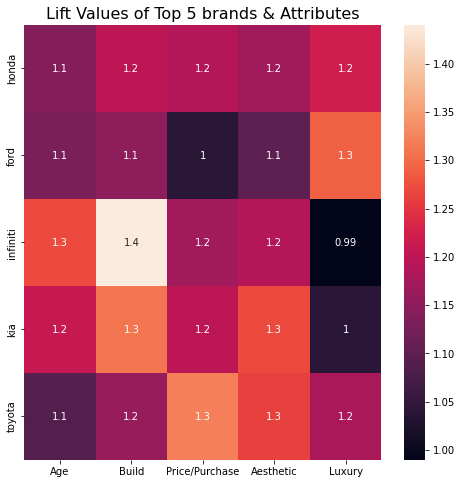

In [65]:
matrix = pd.DataFrame(lift_matrix, dtype="float")
sns.heatmap(matrix, annot=True)
plt.title('Lift Values of Top 5 brands & Attributes', fontsize=16)
plt.savefig(plots_dir+'LiftMatrix_Attributes.png');

## Lift analysis between issues and attributes for each brand

In [ ]:
brands_matrix= pd.read_csv(data_dir+"Brands_Binary.csv")
a = brands_matrix[list(top_5_brands.index)]
b = temp[list(top_5_atts.index)+['Issues']]
df = a.merge(b,right_index = True, left_index = True)
df.head(10)

In [ ]:
# Getting Co - Matrix 

co_matrix_issues = pd.DataFrame(index=top_5_brands.index, columns=top_5_atts.index)
freq_matrix_issues = []
freq_matrix_att = pd.DataFrame(index=[x for x in top_5_brands.index], columns=top_5_atts.index)

i = 0
for brand in top_5_brands.index:
    c = df[df[brand] == True] 
    freq_matrix_issues.append(c[(c.Issues == True)].shape[0])

    for att in top_5_atts.index:
        co_matrix_issues.loc[brand,att] = c[(c.Issues == True) & (c.loc[:,att]==True)].shape[0]
        freq_matrix_att.loc[brand,att] = c[(c.loc[:,att]==True)].shape[0]
      

In [ ]:
lift_matrix_2 = pd.DataFrame(index=[x + ' - Issues' for x in top_5_brands.index], columns=top_5_atts.index)

for i in range(5):
    for j in range(5):
        lift_matrix_2.iloc[i,j] = round(top_5_brands.frequency[i]*(co_matrix_issues.iloc[i,j]/(freq_matrix_issues[i]*freq_matrix_att.iloc[i,j])),3)

In [ ]:
lift_matrix_2

In [ ]:
pd.DataFrame(lift_matrix_2[['Aesthetic', 'Luxury']].mean(axis = 1).nlargest(5), columns = ['average lift (Luxury + Aesthetic)'])

In [ ]:
pd.DataFrame(lift_matrix[['Aesthetic', 'Luxury']].mean(axis = 1).nlargest(5), columns = ['average lift (Luxury + Aesthetic)'])